Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Step: 0 Loss: 772949760.0
Step: 50 Loss: 31734144.0
Step: 100 Loss: 19148970.0


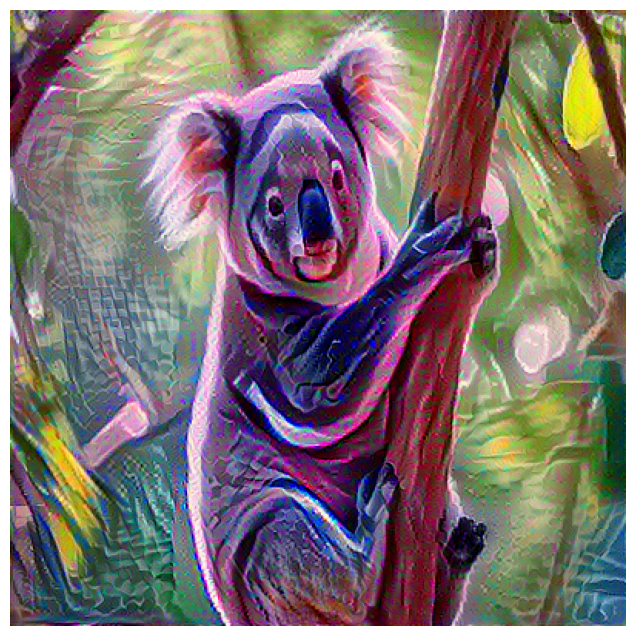

Saved to: /content/drive/MyDrive/DL LANJUT/FOTO/hasil_style_transfer.jpg


In [5]:
# ================================================
#   NATURAL STYLE TRANSFER (NST) - GOOGLE COLAB
#   Content: Koala.jpg
#   Style:   Liquid Images.jpg
# ================================================

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K

# --------- 1. LOAD GDRIVE ----------
from google.colab import drive
drive.mount('/content/drive')

# --------- 2. IMAGE LOADING ----------
content_path = "/content/drive/MyDrive/DL LANJUT/FOTO/Koala.jpg"
style_path   = "/content/drive/MyDrive/DL LANJUT/FOTO/Liquid Images.jpg"

def load_and_process_image(path):
    img = kp_image.load_img(path, target_size=(400, 400))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((400, 400, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

# --------- 3. DEFINE CONTENT & STYLE LAYERS ----------
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1','block2_conv1',
    'block3_conv1','block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# --------- 4. LOAD VGG19 ----------
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    model = models.Model(vgg.input, outputs)
    return model

# --------- 5. STYLE & CONTENT LOSS ----------
def gram_matrix(tensor):
    x = tf.reshape(tensor, (-1, tensor.shape[-1]))
    n = tf.shape(x)[0]
    gram = tf.matmul(x, x, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    outputs = model(init_image)

    style_output_features = outputs[:num_style_layers]
    content_output_features = outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        gram_comb_style = gram_matrix(comb_style)
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_comb_style - target_style))

    weight_per_content_layer = 1.0 / float(num_content_layers)

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content - target_content))

    loss = style_weight * style_score + content_weight * content_score
    return loss, style_score, content_score

# --------- 6. INIT MODEL ----------
model = get_model()
for layer in model.layers:
    layer.trainable = False

style_features = model(style_image)[:num_style_layers]
content_features = model(content_image)[num_style_layers:]
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

# --------- 7. OPTIMIZATION ----------
init_image = tf.Variable(content_image, dtype=tf.float32)
opt = tf.optimizers.Adam(learning_rate=5.0) # Changed 5 to 5.0

style_weight = 1e-2
content_weight = 1e4

@tf.function
def train_step(init_image):
    with tf.GradientTape() as tape:
        loss, _, _ = compute_loss(
            model,
            (style_weight, content_weight),
            init_image,
            gram_style_features,
            content_features
        )
    grad = tape.gradient(loss, init_image)
    opt.apply_gradients([(grad, init_image)])
    init_image.assign(tf.clip_by_value(init_image, -128, 128))
    return loss

# --------- 8. TRAIN LOOP ----------
epochs = 150
for i in range(epochs):
    loss = train_step(init_image)
    if i % 50 == 0:
        print("Step:", i, "Loss:", loss.numpy())

# --------- 9. SHOW RESULT ----------
result = deprocess_image(init_image.numpy())
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.show()

# --------- 10. SAVE TO DRIVE ----------
save_path = "/content/drive/MyDrive/DL LANJUT/FOTO/hasil_style_transfer.jpg"
PIL.Image.fromarray(result).save(save_path)

print("Saved to:", save_path)
